# Support Vector Machine



Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of
performing linear or nonlinear classification, regression, and even outlier detection.

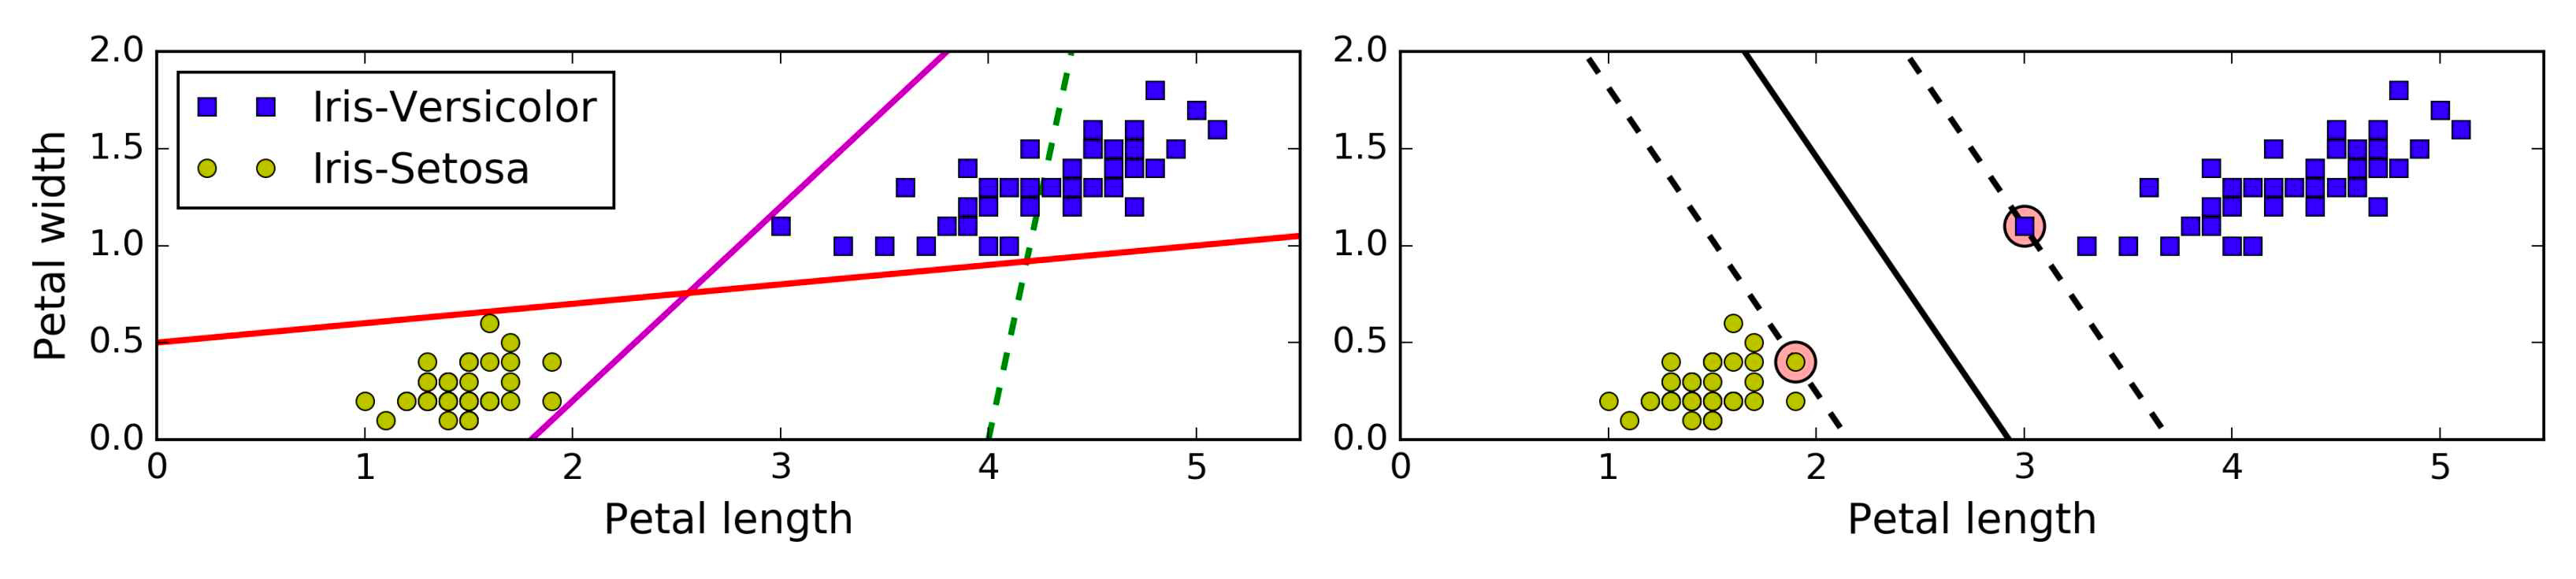

The image on the right is SVM
You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called large
margin classification.

Notice that **adding more training instances “off the street” will not affect the decision boundary at all: it is
fully determined (or “supported”) by the instances located on the edge of the street. These instances are
called the support vectors, they are circled in the right image.**

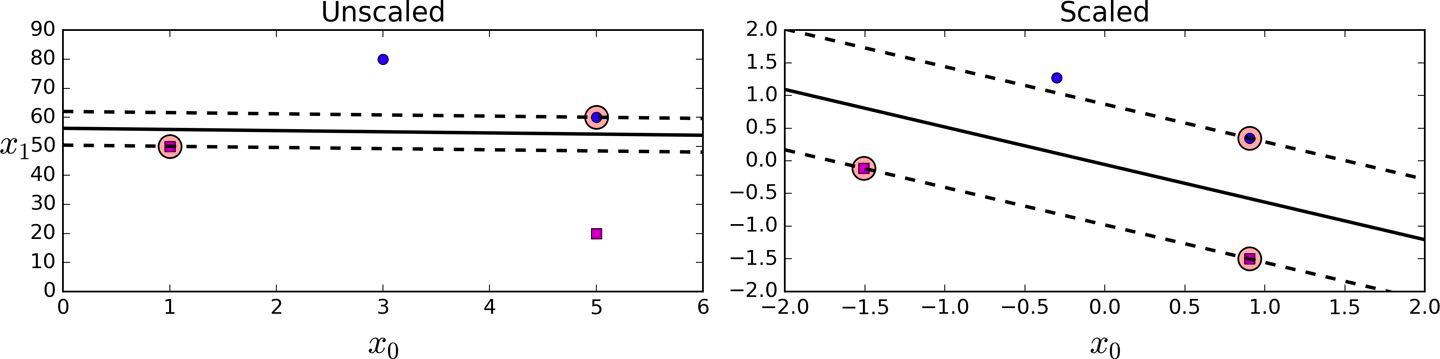

SVM's are sensitive to the feature scales, as you can see in the above figure: on the left plot, the vertical scale is much larger than the horizontal scale, so the widest possible street is close to horizontal. After feature scaling (e.g., using Scikit-Learn’s StandardScaler), the decision boundary looks much better (on the right plot).

## Soft margin classification

If we strictly impose that all instances be off the street and on the right side, this is called hard margin
classification.
There are two main issues with hard margin classification.
1. First, it only works if the datais linearly separable
1. And second it is quite sensitive to outliers. 



Below figure shows the iris dataset withjust one additional outlier: 
+ on the left, it is impossible to find a hard margin, 
+ and on the right the decision boundary ends up very different from the one we saw in the top figure without the outlier, and it will probably not generalize as well.


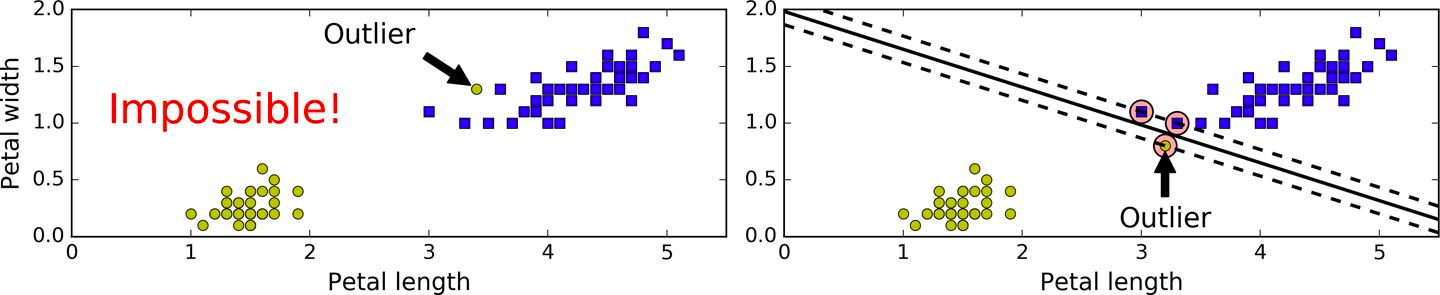

The objective is to 
+ find a good balance between keeping the street as large as possible 
+ and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side).


**This is called soft margin classification.**

In Scikit-Learn’s SVM classes, you can control this balance using the **C hyperparameter**:
A smaller C value leads to a wider street but more margin violations. 


Below shows the decision boundaries and margins of two soft margin SVM classifiers on a nonlinearly separable dataset.
+ On the left, using a high C value the classifier makes fewer margin violations but ends up with a smaller margin. 
+ On the right, using a low C value the margin is much larger, but many instances end up on the street. 


However, it seems likely that the second classifier will generalize better: in fact even on this training set it makes fewer prediction errors, since most of the margin violations are actually on the correct side of the decision boundary.

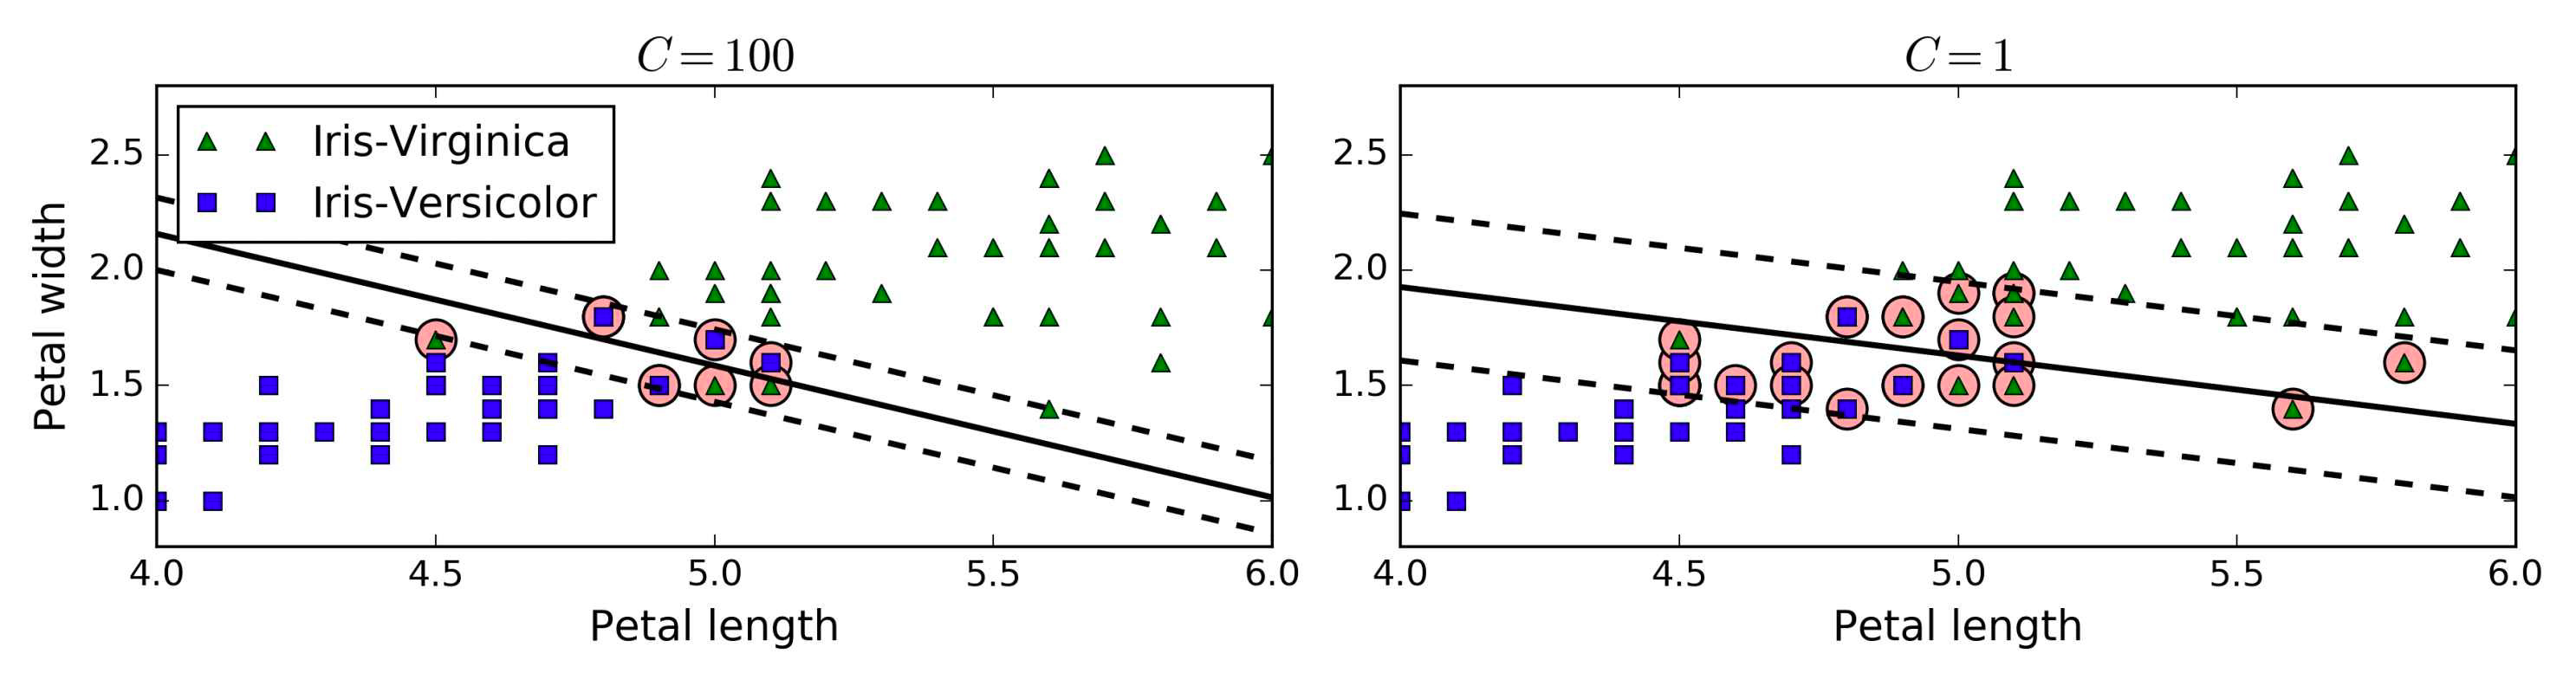

**If your SVM model is overfitting, you can try regularizing it by reducing C.**

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC


iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica
svm_clf = Pipeline((
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge")),
))
svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [2]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

**Unlike Logistic Regression classifiers, SVM classifiers do not output probabilities for each class**

Another option is to use the SGDClassifier
class, with `SGDClassifier(loss="hinge", alpha=1/(m*C))`. 
This applies regular Stochastic Gradient Descent (see Chapter 4) to train a linear SVM classifier. It does not converge as fast as the LinearSVC class, but it can be useful to handle huge datasets that do not fit in memory (out-of-core
training), or to handle online classification tasks.

## Nonlinear SVM Classification


One approach to handling nonlinear datasets is to add more features, such as polynomial features (as you did in Chapter 4); in some cases this can result in a linearly separable dataset.

Consider the left plot: it represents a simple dataset with just one feature x1. This dataset is not linearly separable, as you can see. But if you add a second feature x2 = (x1)<sup>2</sup>, the
resulting 2D dataset is perfectly linearly separable.


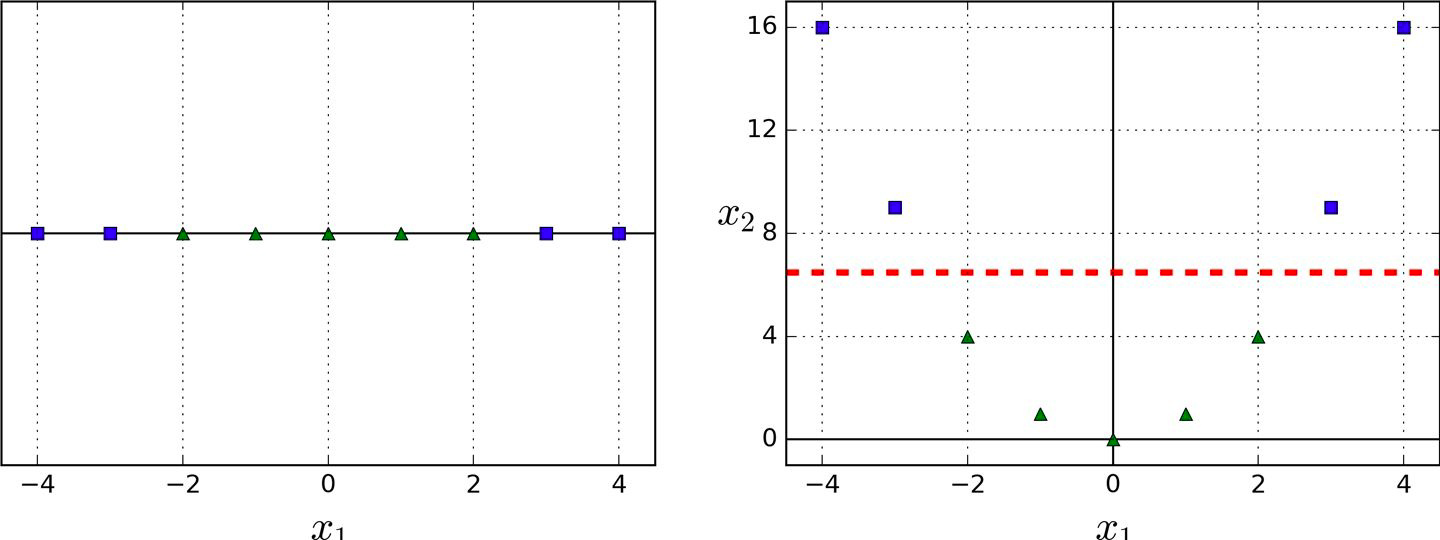

To implement this idea using Scikit-Learn, you can create a `Pipeline containing a PolynomialFeatures
transformer , followed by a StandardScaler and a LinearSVC.`

Let’s test this on the moons dataset


In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100)

polynomial_svm_clf = Pipeline((
("poly_features", PolynomialFeatures(degree=3)),
("scaler", StandardScaler()),
("svm_clf", LinearSVC(C=10, loss="hinge"))
))
polynomial_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning
algorithms (not just SVMs),
+ but at a low polynomial degree it cannot deal with very complex datasets,
+ and with a high polynomial degree it creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the
**kernel trick**. 
It makes it possible to get the same result as 
+ if you added many polynomial features, even with very high-degree polynomials, without actually having to add them. So
+ there is no combinatorial explosion of the number of features since you don’t actually add any features.

This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [4]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline((
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
))
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

+ This code trains an SVM classifier using a 3rd-degree polynomial kernel. It is represented on the left. 
+ On the right is another SVM classifier using a 10th-degree polynomial kernel. 

Obviously, 
+ if your model is overfitting, you might want to reduce the polynomial degree.
+ Conversely, if it is underfitting, you can try increasing it. 

The hyperparameter coef0 controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

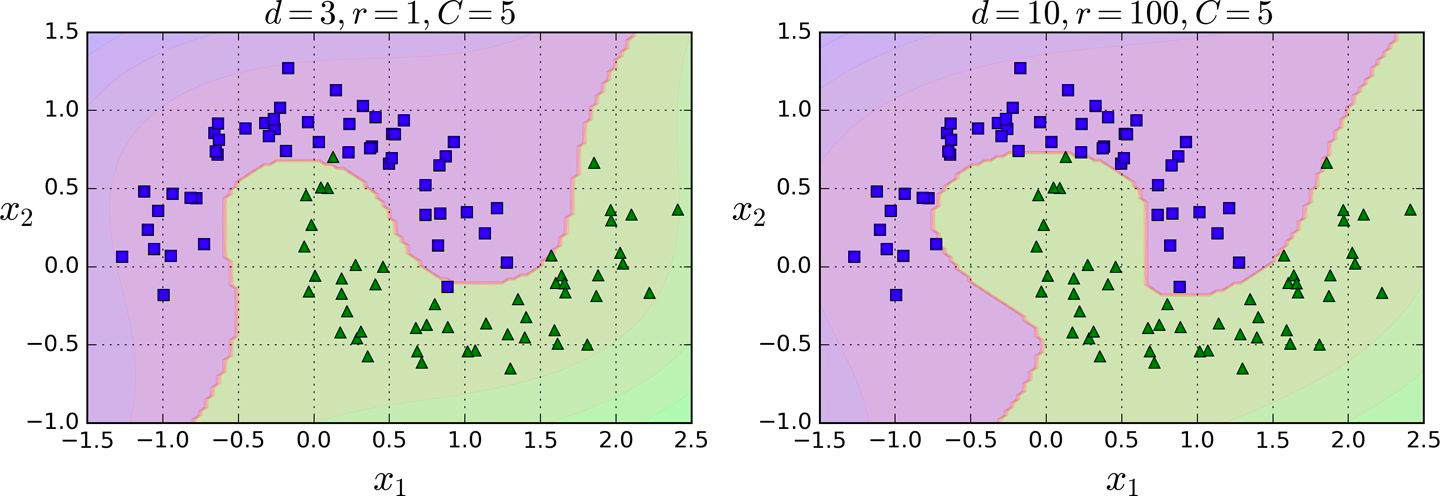